In [ ]:
! pip install -q kaggle
! pip install Pillow
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eugeniamawuenyaakpo","key":"1e072e5a91670a93393deac504a48ac5"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 658M/675M [00:04<00:00, 141MB/s]
100% 675M/675M [00:04<00:00, 144MB/s]


In [ ]:
!mkdir datasets
!unzip cell-images-for-detecting-malaria.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: datasets/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: datasets/cell_imag

In [ ]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "skorch"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [ ]:
import pandas as pd
from PIL import Image
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
labels = ['Parasitized','Uninfected']
img_size = 224
def get_data(data_dir):
  data = [] 
  for label in labels: 
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)


In [ ]:
data=get_data(r'datasets/cell_images')

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


<ipython-input-3-5581448f52d6>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
data.shape

(27558, 2)

<Axes: ylabel='count'>

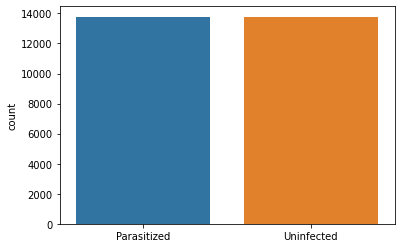

In [ ]:
lab = []
for i in data:
  if(i[1] == 0):
    lab.append("Parasitized")
  else:
    lab.append("Uninfected")
# print(lab)
# sns.load_dataset(lab)
sns.countplot(x=lab)

Text(0.5, 1.0, 'Parasitized')

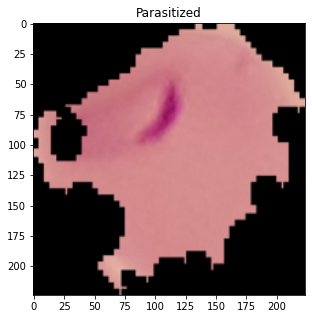

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(data[0][0])
plt.title(labels[data[0][1]])

Text(0.5, 1.0, 'Uninfected')

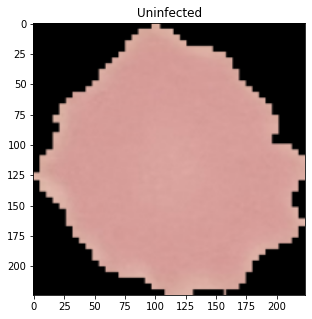

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(data[-1][0])
plt.title(labels[data[-1][1]])

In [ ]:
import random

# Assuming X is your image dataset
num_images = data.shape[0]
indices = random.sample(range(num_images), k=1000)

# Select 1000 images using the randomly selected indices
data_sampled = data[indices]

In [ ]:
X = []
y = []
for i in data_sampled:
  X.append(i[0])
  y.append(i[1])

X= np.array(X)/255
y=np.array(y)

In [ ]:
X.shape

(1000, 224, 224, 3)

In [ ]:
X = X.transpose(0, 3, 1, 2)
X.shape


(1000, 3, 224, 224)

In [ ]:
data[196][1]

0

In [ ]:
from torch import nn

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [ ]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(ClassifierModule)

In [ ]:
import torch
from sklearn.model_selection import cross_val_predict

# # convert X from (1000, 3, 224, 224) to (1000, 1, 224, 224)
gray = 0.2989 * X[:, 0] + 0.5870 * X[:, 1] + 0.1140 * X[:, 2]
gray = torch.from_numpy(gray).unsqueeze(1).float()


num_crossval_folds = 3
pred_probs = cross_val_predict(
    model_skorch,
    gray,  # use the grayscale images instead of the original RGB images
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)



  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.9622       0.4851        2.1474  23.2183
      2        1.0026       0.3284        2.2473  14.0946
      3        0.7082       0.4478        2.2757  14.0468
      4        0.6051       0.4179        2.2204  14.0538
      5        0.7861       0.4851        2.0418  14.5043
      6        0.5907       0.4851        1.7706  16.3504
      7        0.5227       0.4851        1.4385  13.8115
      8        0.4848       0.6493        1.0758  13.7926
      9        0.8519       0.6418        1.0289  13.8200
     10        0.4825       0.6567        0.7987  13.8525
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3111       0.4776        2.2240  13.6810
      2        0.9620       0.2836        2.3249  13.5086
      3        0.7214       0.2537        2.3517  13.5054
      4       

In [ ]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.653


In [ ]:
print(y.shape)
print(pred_probs.shape)

(1000,)
(1000, 10)


In [ ]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 311 label issues.
Top 15 most likely label errors: 
 [ 21  88 886 747 646 765 759 731 180 130 332 991 741 778 884]


/usr/local/lib/python3.9/dist-packages/cleanlab/filter.py:1045: UserWarning: May not flag all label issues in class: 2, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cleanlab/filter.py:1045: UserWarning: May not flag all label issues in class: 3, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cleanlab/filter.py:1045: UserWarning: May not flag all label issues in class: 4, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cleanlab/filter.py:1045: UserWarning: May not flag all label issues in class: 5, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cleanlab/filter.py:1045: UserWarning: May not flag all label issues in class: 6, it has too few examples (see `min_examples_per_class` argument)
  warnings.w

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_examples(id_iter, nrows=1, ncols=1):
  plt.figure(figsize=(8,8))
  for count, id in enumerate(id_iter):
      img = np.transpose(X[id], (1, 2, 0)) # Convert from (3, 224, 224) to (224, 224, 3)
      
      plt.subplot(nrows, ncols, count + 1)
      plt.imshow(img)
      plt.title(f"id: {id} \n label: {y[id]}")
      plt.axis("off")

  plt.tight_layout(h_pad=2.0)


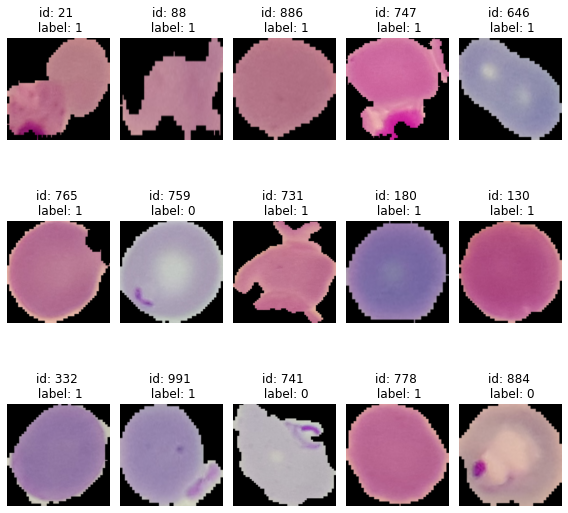

In [ ]:
plot_examples(ranked_label_issues[range(15)], 3, 5)

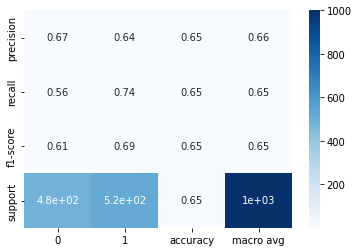

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

predicted_labels = pred_probs.argmax(axis=1)
report = classification_report(y, predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='Blues')
plt.show()

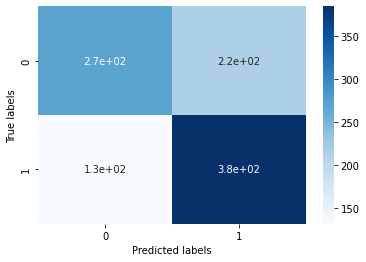

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_labels = pred_probs.argmax(axis=1)
cm = confusion_matrix(y, predicted_labels)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
